In [20]:
import pandas as pd
import numpy as np
import random
random.seed(2020)

# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pylab as plt
from sklearn import preprocessing

import lightgbm as lgb
# import xgboost as xgb
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import GradientBoostingClassifier

import missingno as msno
import seaborn as sns

In [21]:
df = pd.read_csv("Train.csv")
y = df.target
x = df[["Policy Start Date", "Policy End Date", "Gender", "Age", "First Transaction Date", "No_Pol",
        "Car_Category", "Subject_Car_Colour", "Subject_Car_Make", "LGA_Name", "State", "ProductName"]]
variables = pd.read_csv("VariableDefinitions.csv")
variables

,ID,Unique ID for the customer
0,Policy Start Date,Date policy started
1,Policy End Date,Date policy ended
2,Gender,Gender of the customer
3,Age,Age of the customer
4,ProductName,Name of Insurance policy
5,First Transaction Date,First date payment was made
6,No_Pol,Number of policies the customer has
7,Car_Category,Type of car
8,Subject_Car_Colour,Car colour
9,Subject_Car_Make,Car make


In [22]:
# le = preprocessing.LabelEncoder()
# x.Car_Category = le.fit_transform(x.Car_Category)

In [23]:
colors = ['Black', 'Silver', 'Grey', 'Blue', 'White', 'Red', 'Green', 'Gold', 'Ash', 'Wine', 'Brown']
def replace_color(color):
    if color not in colors:
        return random.choice(colors)
    return color
x.Subject_Car_Colour = x.Subject_Car_Colour.apply(replace_color)
le = preprocessing.LabelEncoder()
x.Subject_Car_Colour = le.fit_transform(x.Subject_Car_Colour)

c:\Users\barto\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [24]:
cars = ['Saloon', 'JEEP', 'Truck', 'Bus', 'Mini Bus', 'Pick Up', 'Motorcycle', 'Mini Van', 'Sedan', 'Wagon']
def replace_car(car):
    if car not in cars:
        return random.choice(cars)
    return car
x.Car_Category = x.Car_Category.apply(replace_car)
le = preprocessing.LabelEncoder()
x.Car_Category = le.fit_transform(x.Car_Category)

In [25]:
ages = x.Age.sort_values()
ages[3427] = 60
ages[3518] = 59
ages[5173] = 59
ages[909] = 76
ages[10713] = 76
ages = ages.sort_values()

def fillwith42(x):
    if x >= 15 and x <= 18:
        return 16
    elif x >= 18 and x <= 93:
        return x
    else:
        return 42
    
ages = ages.apply(lambda age: -age if age < 0 else age)
ages = ages.apply(fillwith42)
ages = ages.sort_values()
x.Age = ages

In [26]:
def other_gender(gender):
    if gender not in ["Male", "Female"]:
        return "Other"
    return gender

x.Gender = x.Gender.apply(other_gender)

legender = preprocessing.LabelEncoder()
x.Gender = legender.fit_transform(x.Gender)

In [27]:
# x["Policy Start Date"] = pd.to_datetime(x["Policy Start Date"], format = "%Y-%m-%d")
# x["Policy End Date"] = pd.to_datetime(x["Policy End Date"], format = "%Y-%m-%d")

# x["start_yearmonth"] = -((2022 - x["Policy Start Date"].dt.year)*100 + x["Policy Start Date"].dt.month)
# x["end_yearmonth"] = (-x["Policy End Date"].dt.year)*100 + x["Policy End Date"].dt.month

# x["start_yearweek"] = 

<AxesSubplot:>

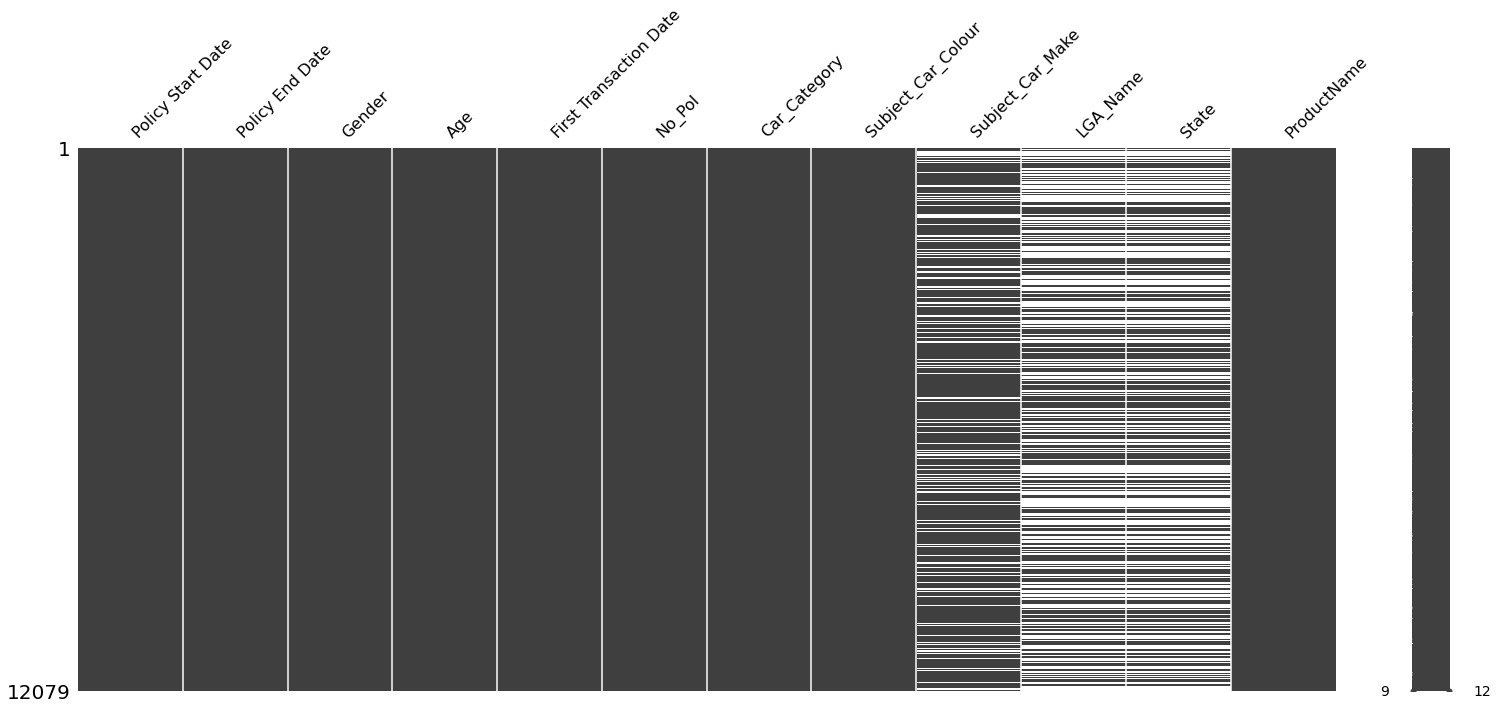

In [28]:
msno.matrix(x)

In [29]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

In [30]:
x

,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,2010-05-14,2011-05-13,1,30,2010-05-14,1,6,1,TOYOTA,NaN,NaN,Car Classic
1,2010-11-29,2011-11-28,0,79,2010-11-29,1,1,6,TOYOTA,NaN,NaN,Car Classic
2,2010-03-21,2011-03-20,1,43,2010-03-21,1,6,7,TOYOTA,NaN,NaN,Car Classic
3,2010-08-21,2011-08-20,1,42,2010-08-21,1,8,10,NaN,NaN,NaN,CarSafe
4,2010-08-29,2010-12-31,2,20,2010-08-29,3,7,10,NaN,Lagos,Lagos,Muuve
...,...,...,...,...,...,...,...,...,...,...,...,...
12074,2010-05-25,2011-05-24,0,30,2010-05-25,1,2,1,Range Rover,Ibeju/Lekki,Ibeju-Lekki,Car Classic
12075,2010-10-03,2011-10-02,0,59,2010-10-03,1,6,4,NaN,NaN,NaN,Car Classic
12076,2010-10-10,2011-10-08,1,34,2010-10-10,1,9,8,NaN,NaN,NaN,CarSafe
12077,2010-02-27,2011-02-26,2,42,2010-02-27,2,8,9,TOYOTA,Victoria Island,Lagos,CVTP


In [31]:
x[["Policy Start Date", "Policy End Date", "First Transaction Date",
   "Subject_Car_Make", "LGA_Name", "State", "ProductName"]] = x[["Policy Start Date", "Policy End Date", "First Transaction Date",
   "Subject_Car_Make", "LGA_Name", "State", "ProductName"]].astype("category")

c:\Users\barto\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [32]:
score = 0
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=2020)
for train_index, test_index in kf.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    # model = lgb.LGBMClassifier(metric = [lgb_f1_score])
    model = lgb.LGBMClassifier()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    scorep = f1_score(y_pred, y_test)
    score += scorep
print("lightgbm mean f1_score:", score/5)

lightgbm mean f1_score: 0.22176207640704973


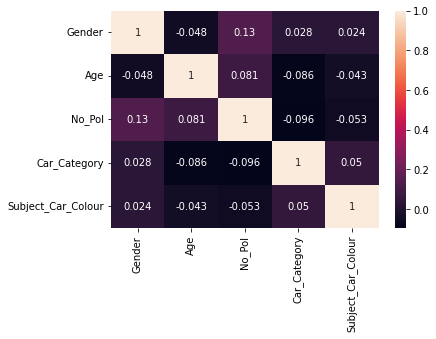

In [33]:
corrMatrix = x.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()